In [3]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
import os
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from wordcloud import WordCloud

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"
df_train_prompt = pd.read_csv(DIR + 'prompts_train.csv')
df_train_summaries = pd.read_csv(DIR + 'summaries_train.csv')

### Check for missing values

In [5]:
df_train_prompt.isna().sum()

prompt_id          0
prompt_question    0
prompt_title       0
prompt_text        0
dtype: int64

In [6]:
df_train_summaries.isna().sum()

student_id    0
prompt_id     0
text          0
content       0
wording       0
dtype: int64

# Merging the datasets

In [7]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


### Describing the dataset

In [8]:
df_train_prompt['prompt_title'].value_counts()

On Tragedy                   1
Egyptian Social Structure    1
The Third Wave               1
Excerpt from The Jungle      1
Name: prompt_title, dtype: int64

There are 4 prompts provided to us in the training dataset. The summaries are based on these 4 prompts.

In [9]:
df_train_summaries[df_train_summaries.groupby('student_id', as_index=False)['text'].count().apply(lambda x: x['text'] > 1, axis=1)]

,student_id,prompt_id,text,content,wording


Hmm, summaries appear to be one-of-a-kind ;-) Is this correct? As a student who summarized in those grades, I believe there is a problem here. such these students must be completely honest, or a couple of students must be clever enough to slightly alter their summaries such that they cannot be identified immediately. So we should look at the status of students' summaries further :)

# Research 1 - Get Intuition from the (content, wording) student's summaries
#### Content and Wording Correlation
Let's see how the two scores are correlated with each other.

<Axes: xlabel='content', ylabel='wording'>

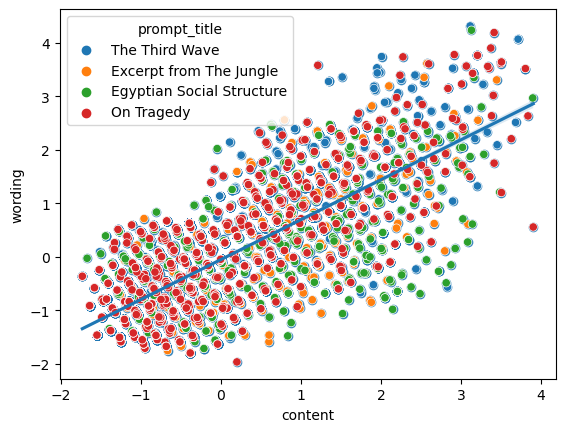

In [10]:
sns.regplot(x='content', y='wording', data=df_train)
sns.scatterplot(x='content', y='wording', data=df_train, hue='prompt_title')

In [11]:
grouped_counts = df_train.groupby(['content', 'wording']).size().reset_index(name='count')

sorted_grouped_counts = grouped_counts.sort_values(by='count', ascending=False)
print(sorted_grouped_counts)


       content   wording  count
4    -1.547163 -1.461245    426
437   0.205683  0.380538    380
355  -0.093814  0.503833    286
33   -1.264214 -1.505073    173
458   0.297031 -0.168734    171
...        ...       ...    ...
586   0.765705  1.336717      1
587   0.766599  2.271993      1
589   0.767218 -0.208948      1
590   0.772118  1.060683      1
1133  3.900326  0.556480      1

[1134 rows x 3 columns]


Conclusions:


*   the length is very short
*   it copy pastes most of the times an extract from the prompt_text
*   Central Tendency
*   Replicability - Dataset need to be cleaned




# Research 2 - What's correlation btw prompts with the summaries

In [12]:
df_train.groupby(['prompt_title'])['content'].describe()

,count,mean,std,min,25%,50%,75%,max
prompt_title,,,,,,,,
Egyptian Social Structure,2009.0,0.049579,1.106129,-1.729859,-0.799545,-0.093814,0.702059,3.894070
Excerpt from The Jungle,1996.0,-0.087906,0.990271,-1.638511,-0.861984,-0.093814,0.440020,3.503226
On Tragedy,2057.0,-0.095457,0.969773,-1.729859,-0.810574,-0.157460,0.297031,3.900326
The Third Wave,1103.0,0.150306,1.124158,-1.729859,-0.627647,-0.093814,0.793637,3.711374


In [13]:
df_train.groupby(['prompt_title'])['wording'].describe()

,count,mean,std,min,25%,50%,75%,max
prompt_title,,,,,,,,
Egyptian Social Structure,2009.0,-0.068542,0.952708,-1.795491,-0.794551,-0.045439,0.506755,4.231226
Excerpt from The Jungle,1996.0,-0.299023,0.930270,-1.795491,-1.050372,-0.284364,0.380538,3.638126
On Tragedy,2057.0,-0.140749,1.055695,-1.962614,-0.970213,-0.168734,0.500911,4.187398
The Third Wave,1103.0,0.518733,1.107806,-1.795491,-0.125597,0.503833,1.133263,4.310693


In [14]:
df_train['prompt_title'].value_counts()

On Tragedy                   2057
Egyptian Social Structure    2009
Excerpt from The Jungle      1996
The Third Wave               1103
Name: prompt_title, dtype: int64

"The Third Wave" has a lower number of prompts than the others.

In [15]:
pearsonr(df_train['content'], df_train['wording'])

(0.7513804859701966, 0.0)

There is a **high positive correlation** between the content and wording scores. Let's breakdown this for the 4 prompts

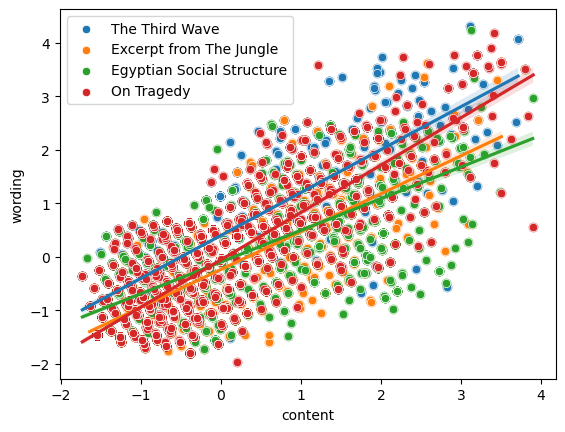

In [16]:
for prompt_title in df_train['prompt_title'].unique():
    sns.regplot(x='content', y='wording', data=df_train[df_train['prompt_title'] == prompt_title])
    sns.scatterplot(x='content', y='wording', data=df_train[df_train['prompt_title'] == prompt_title], label=prompt_title)

In [17]:
for prompt_title in df_train['prompt_title'].unique():
    print(prompt_title)
    print(pearsonr(df_train[df_train['prompt_title'] == prompt_title]['content'], df_train[df_train['prompt_title'] == prompt_title]['wording']))
    print()

The Third Wave
(0.8137912322007287, 9.07008535075149e-262)

Excerpt from The Jungle
(0.7534131842752706, 0.0)

Egyptian Social Structure
(0.687493601347762, 3.479407046102795e-281)

On Tragedy
(0.8129110061670949, 0.0)



Pearson correlation results show p-values near zero, indicating statistical significance due to Python's limitations in floating-point arithmetic and small sample sizes.

# Research 3 - Content and Wording Distribution
## i) Let's have a look at how the two scores (Content and Wording) are distributed.
- **Using Histograms**

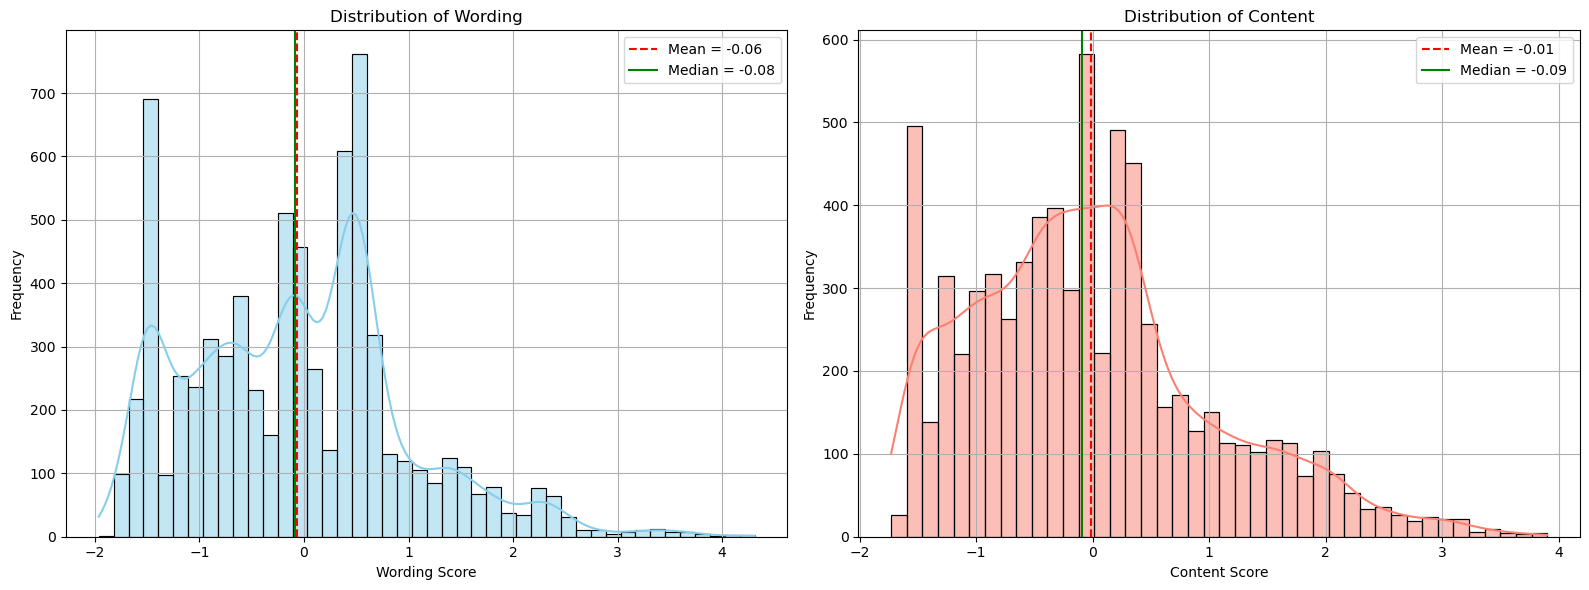

In [18]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train_summaries['wording'], color='skyblue', kde=True)
plt.title("Distribution of Wording")
plt.xlabel("Wording Score")
plt.ylabel("Frequency")
plt.grid(True)
mean_wording = np.mean(df_train_summaries['wording'])
median_wording = np.median(df_train_summaries['wording'])
plt.axvline(mean_wording, color='r', linestyle='--', label=f"Mean = {mean_wording:.2f}")
plt.axvline(median_wording, color='g', linestyle='-', label=f"Median = {median_wording:.2f}")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_train_summaries['content'], color='salmon', kde=True)
plt.title("Distribution of Content")
plt.xlabel("Content Score")
plt.ylabel("Frequency")
plt.grid(True)
mean_content = np.mean(df_train_summaries['content'])
median_content = np.median(df_train_summaries['content'])
plt.axvline(mean_content, color='r', linestyle='--', label=f"Mean = {mean_content:.2f}")
plt.axvline(median_content, color='g', linestyle='-', label=f"Median = {median_content:.2f}")
plt.legend()

plt.tight_layout()
plt.show()


Ideas from Histograms:

- **Using Boxen Plots**

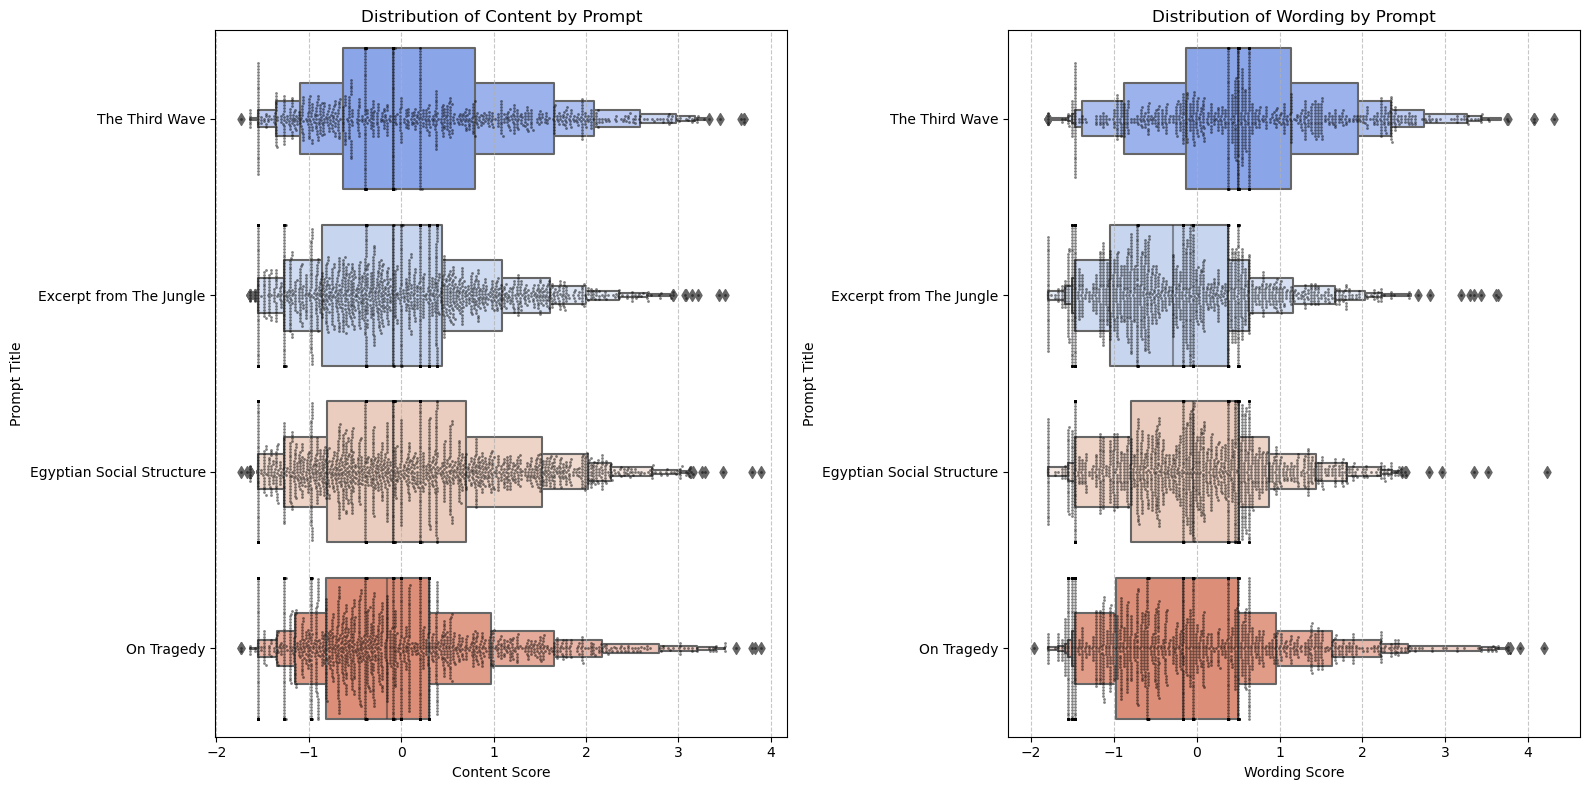

In [19]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.boxenplot(data=df_train, x='content', y='prompt_title', palette='coolwarm')
plt.title("Distribution of Content by Prompt")
plt.xlabel("Content Score")
plt.ylabel("Prompt Title")
plt.grid(True, linestyle='--', alpha=0.7)
sns.swarmplot(data=df_train, x='content', y='prompt_title', color="black", size=2, alpha=0.5)

plt.subplot(1, 2, 2)
sns.boxenplot(data=df_train, x='wording', y='prompt_title', palette='coolwarm')
plt.title("Distribution of Wording by Prompt")
plt.xlabel("Wording Score")
plt.ylabel("Prompt Title")
plt.grid(True, linestyle='--', alpha=0.7)
sns.swarmplot(data=df_train, x='wording', y='prompt_title', color="black", size=2, alpha=0.5)

plt.tight_layout()
plt.show()


## Let's see what happen after rotating the Content and Wording Correlation scatterplot in 30 degrees 

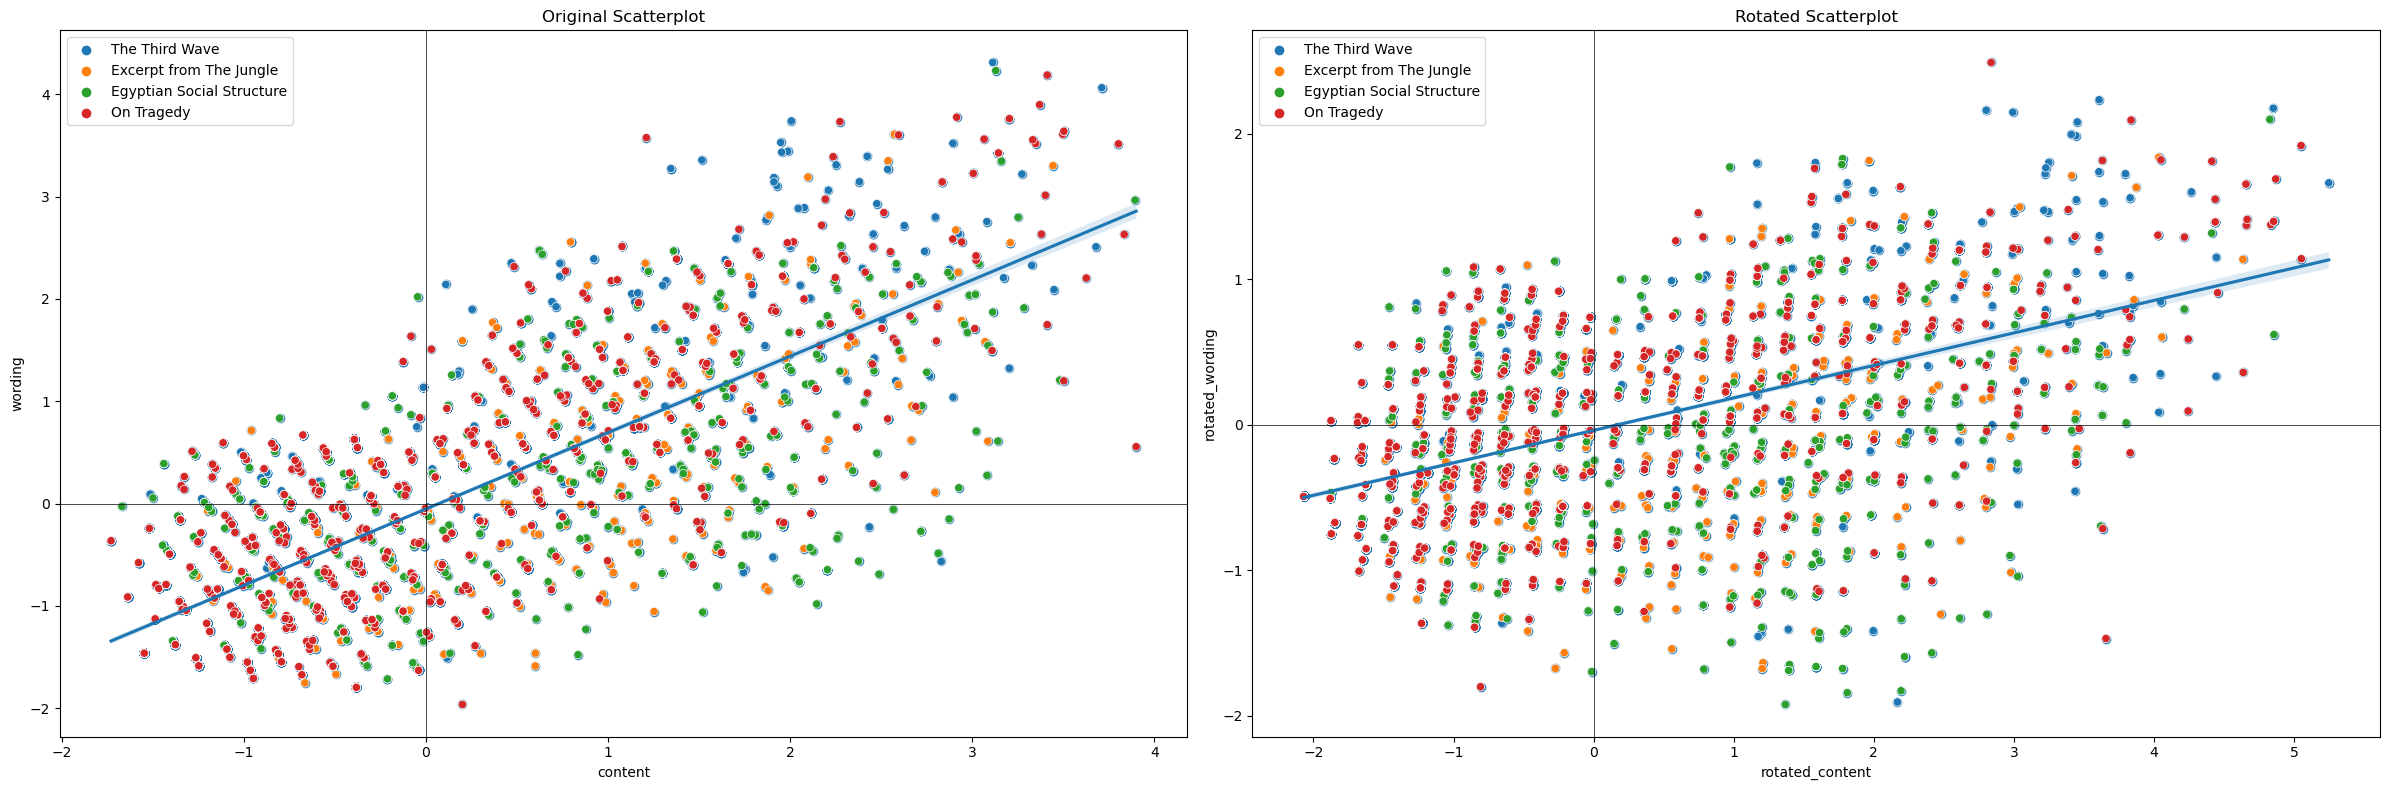

In [20]:
plt.figure(figsize=(24, 8))

angle_deg = 30
angle_rad = np.radians(angle_deg)
rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                            [np.sin(angle_rad), np.cos(angle_rad)]])

rotated_data = df_train[['content', 'wording']].values.dot(rotation_matrix)
df_train_rotated = pd.DataFrame(rotated_data, columns=['rotated_content', 'rotated_wording'])
df_train_rotated['prompt_title'] = df_train['prompt_title']

plt.subplot(1, 2, 1)
sns.regplot(x='content', y='wording', data=df_train)
sns.scatterplot(x='content', y='wording', data=df_train, hue='prompt_title')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.legend()
plt.title("Original Scatterplot")

plt.subplot(1, 2, 2)
sns.regplot(x='rotated_content', y='rotated_wording', data=df_train_rotated)
sns.scatterplot(x='rotated_content', y='rotated_wording', data=df_train_rotated, hue='prompt_title')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.legend()
plt.title("Rotated Scatterplot")

plt.tight_layout()
plt.show()


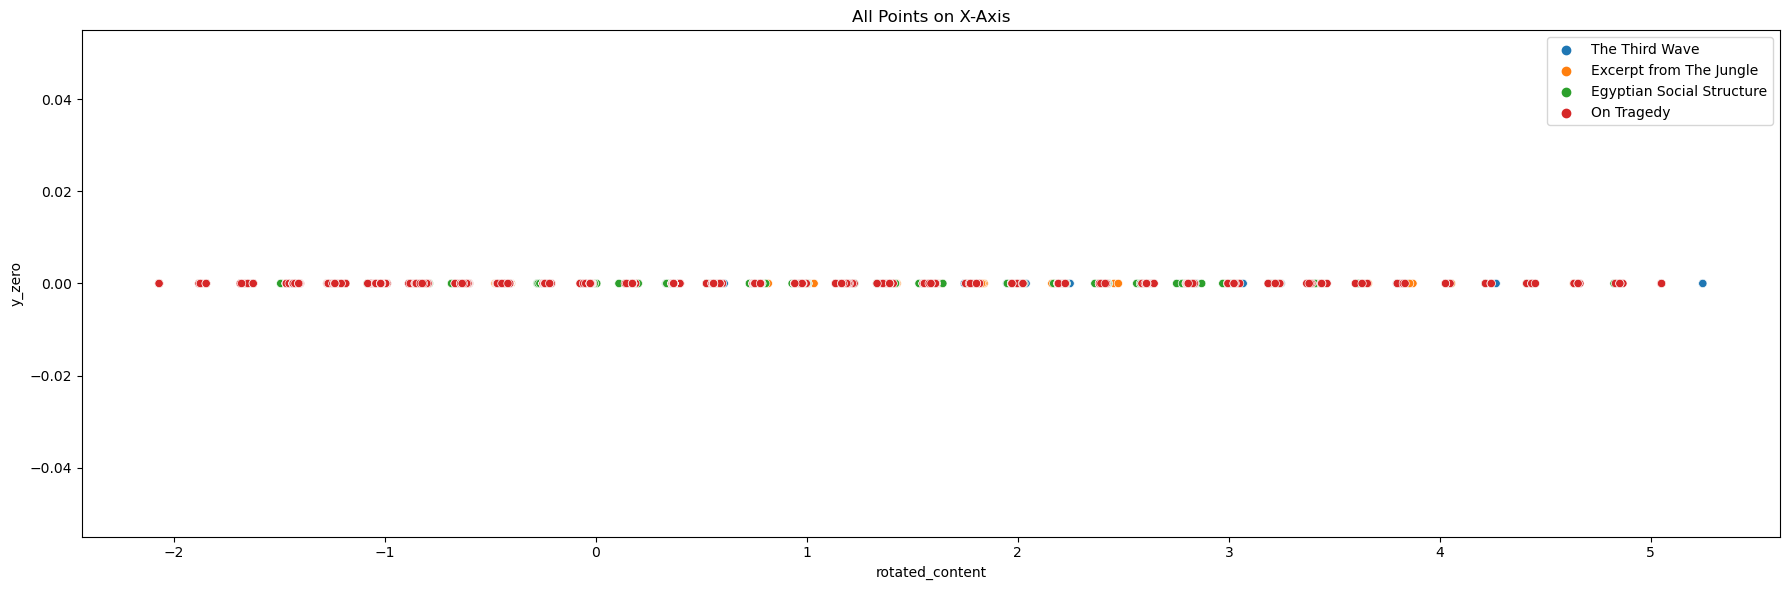

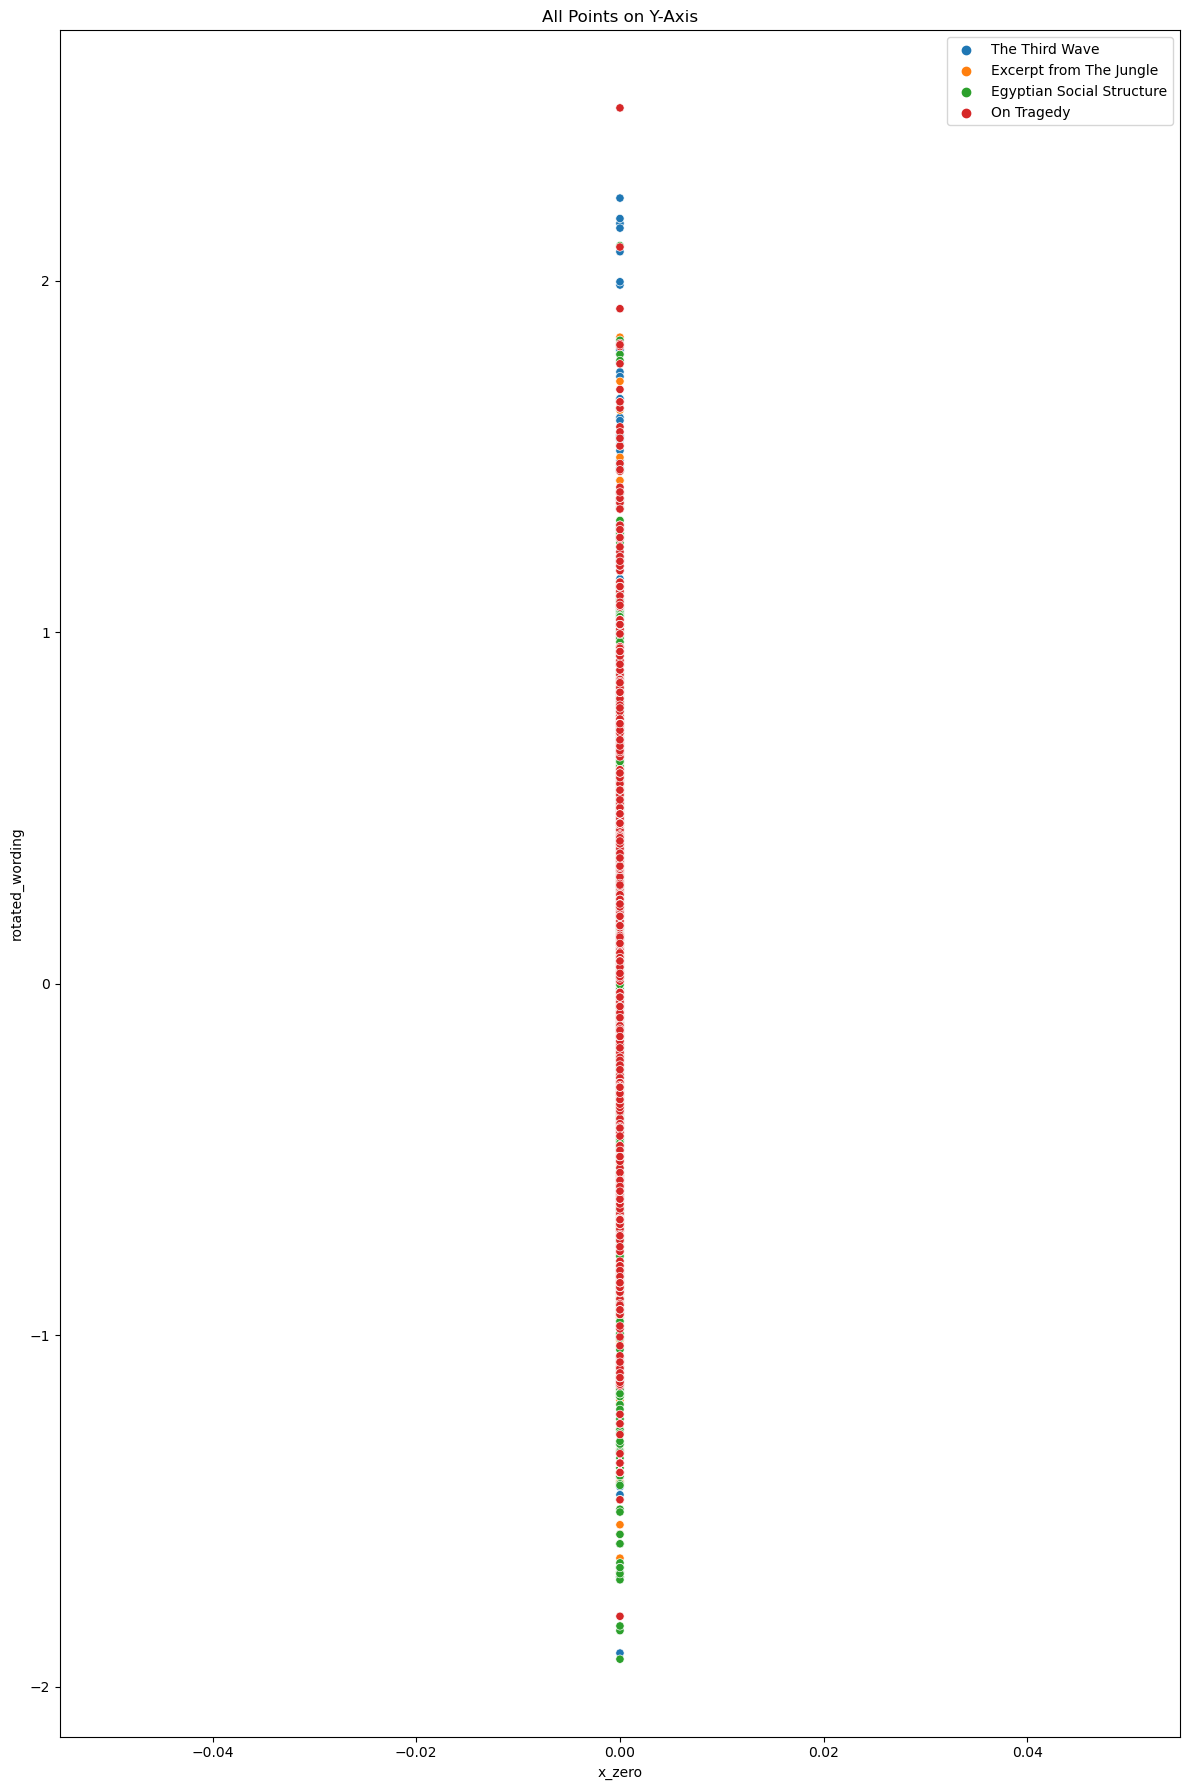

In [21]:
df_train_rotated['y_zero'] = 0
fig1, ax1 = plt.subplots(figsize=(18, 6))
sns.scatterplot(x='rotated_content', y='y_zero', data=df_train_rotated, hue='prompt_title', ax=ax1)
ax1.set_title('All Points on X-Axis')
ax1.legend()
plt.tight_layout()
plt.show()

df_train_rotated['x_zero'] = 0
fig2, ax2 = plt.subplots(figsize=(12, 18))
sns.scatterplot(x='x_zero', y='rotated_wording', data=df_train_rotated, hue='prompt_title', ax=ax2)
ax2.set_title('All Points on Y-Axis')
ax2.legend()
plt.tight_layout()
plt.show()


clearly see 37 content categories. Can estimate the number of wording categories and it seems to be ~20. However, if we train with rotated data we break data standarization as content's new range is between -2 and 5 approximately.

Conclusions: <br>
Need to research about this. Upto now it seems to be this is something that looks pretty close to the number of the content categories. The number of the wording categories is smaller, but may be the wording scores are usually higher than the content ones? It could be pretty simple to reuse words from full texts, but it is much more complicated to properly summarize the content.


# Research 4 - Text Length, How the stop words has effected to the text length and Results
Let's see how the text length of the summaries are distributed.

<Axes: xlabel='text_len', ylabel='prompt_title'>

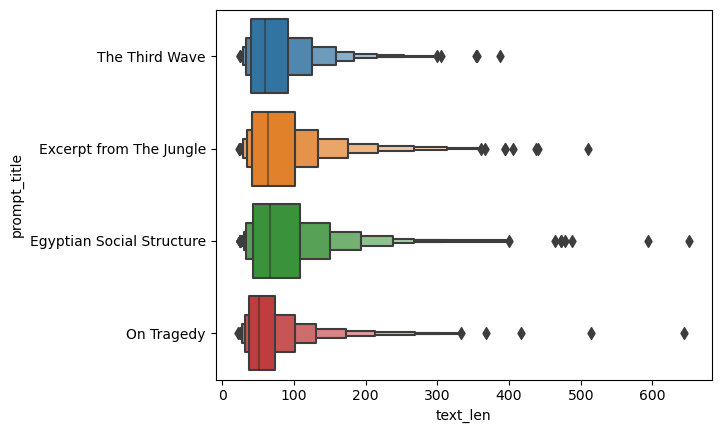

In [22]:

df_train['text_len'] = df_train['text'].apply(lambda x: len(x.split(' ')))
sns.boxenplot(df_train, x='text_len', y='prompt_title')

In [23]:
pearsonr(df_train['text_len'], df_train['wording'])

(0.5315397777313002, 0.0)

In [24]:
for prompt_title in df_train['prompt_title'].unique():
    print(prompt_title)
    print(pearsonr(df_train[df_train['prompt_title'] == prompt_title]['text_len'], df_train[df_train['prompt_title'] == prompt_title]['wording']))
    print()

The Third Wave
(0.6161075892447802, 2.8898672731776945e-116)

Excerpt from The Jungle
(0.5344372677377714, 7.747256653251197e-148)

Egyptian Social Structure
(0.4867551462353104, 5.195607647804163e-120)

On Tragedy
(0.6898878596437986, 1.1640805696326968e-290)



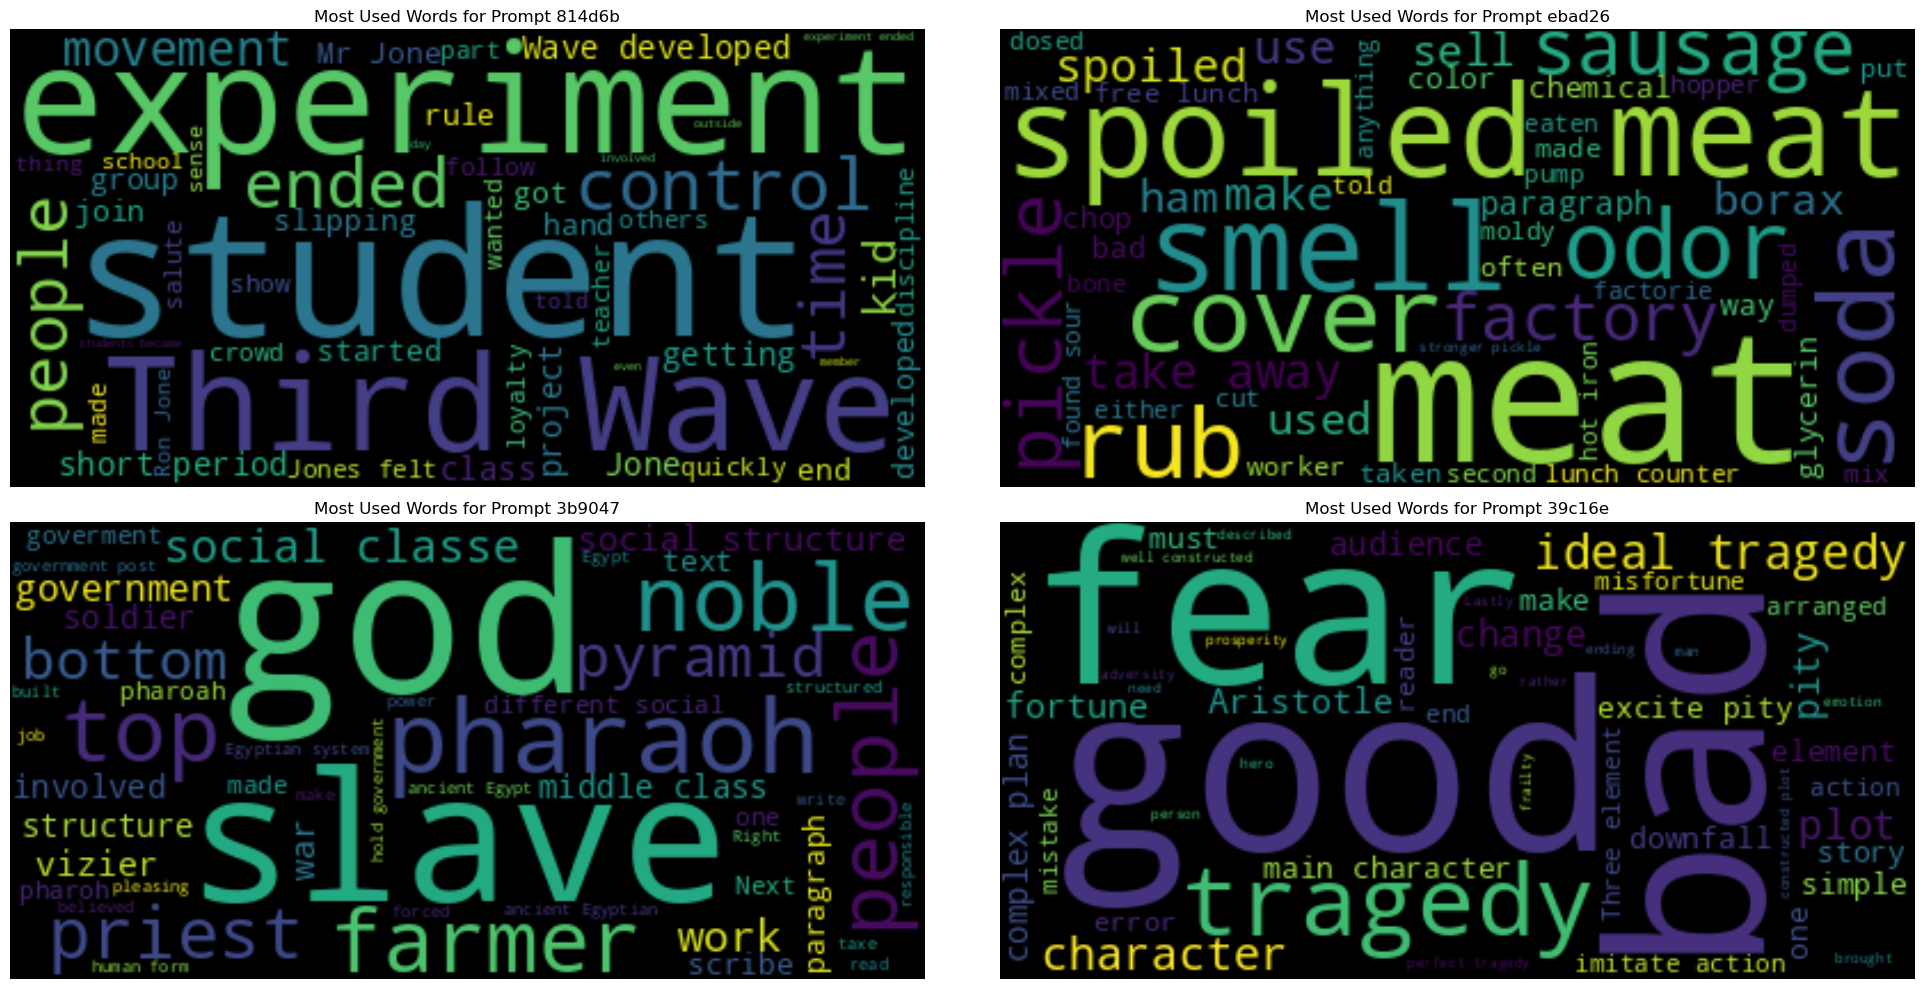

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes = axes.flatten()

unique_prompt_ids = df_train['prompt_id'].unique()

for ax, prompt_id in zip(axes, unique_prompt_ids):
    text = ' '.join(df_train[df_train['prompt_id'] == prompt_id].text.values)
    wc = WordCloud(max_words=50)
    wordcloud = wc.generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Most Used Words for Prompt {prompt_id}")
    ax.axis('off')

for ax in axes[len(unique_prompt_ids):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Check how stop words have contributed to the content and wording

In [26]:
df_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_len
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27
...,...,...,...,...,...,...,...,...,...
7160,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,33
7161,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,30
7162,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,29
7163,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,50


<Axes: xlabel='text_len', ylabel='Count'>

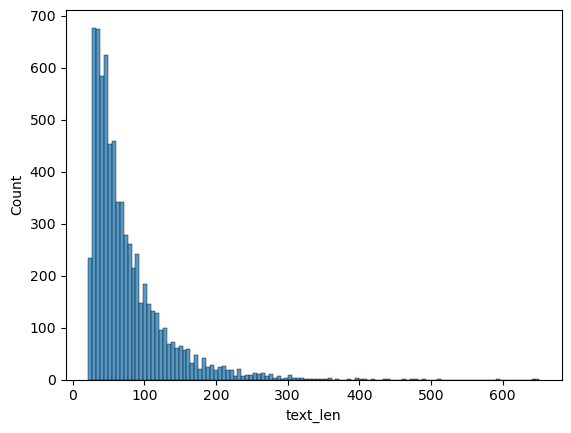

In [27]:
sns.histplot(df_train.text_len)

Text(0.5, 1.0, 'correlation between word count and wording score')

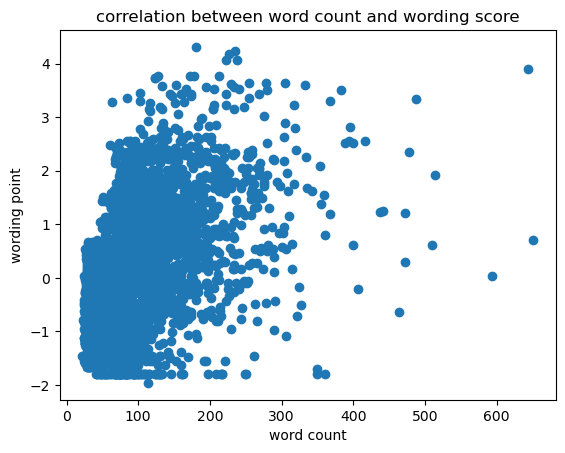

In [28]:
plt.scatter(df_train.text_len, df_train.wording)
plt.xlabel("word count")
plt.ylabel("wording point")
plt.title("correlation between word count and wording score")

Text(0.5, 1.0, 'correlation between word count and content score')

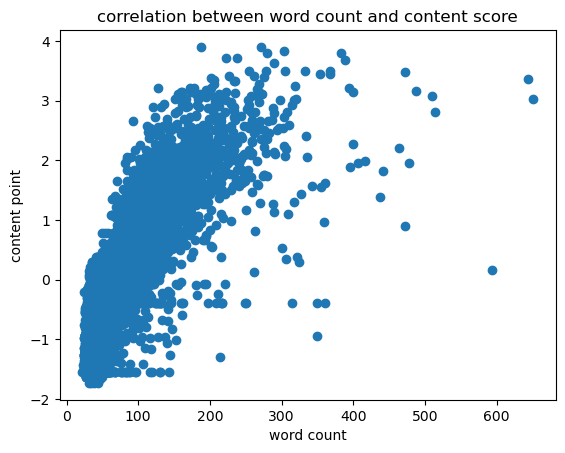

In [29]:
plt.scatter(df_train.text_len, df_train.content)
plt.xlabel("word count")
plt.ylabel("content point")
plt.title("correlation between word count and content score")

In [30]:
def stop_word_count(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)

    stop_word = 0
    for token in word_tokens:
        if token in stop_words:
            stop_word += 1

    return stop_word

df_train['stopword_count'] = df_train['text'].apply(stop_word_count)
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_len,stopword_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,21
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,81
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,25
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,35
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,10


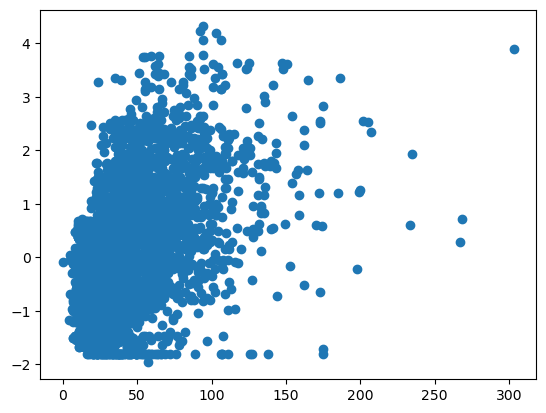

In [31]:
plt.scatter(data=df_train, x='stopword_count', y='wording')

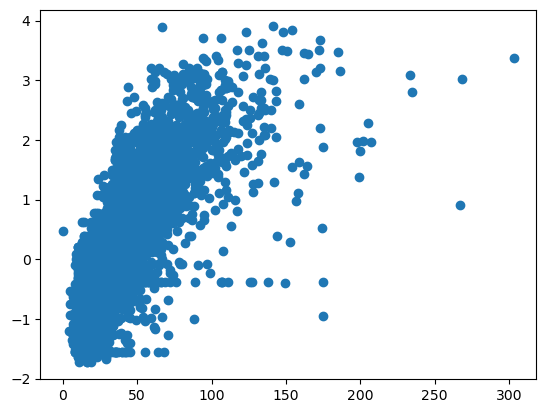

In [32]:
plt.scatter(data=df_train, x='stopword_count', y='content')

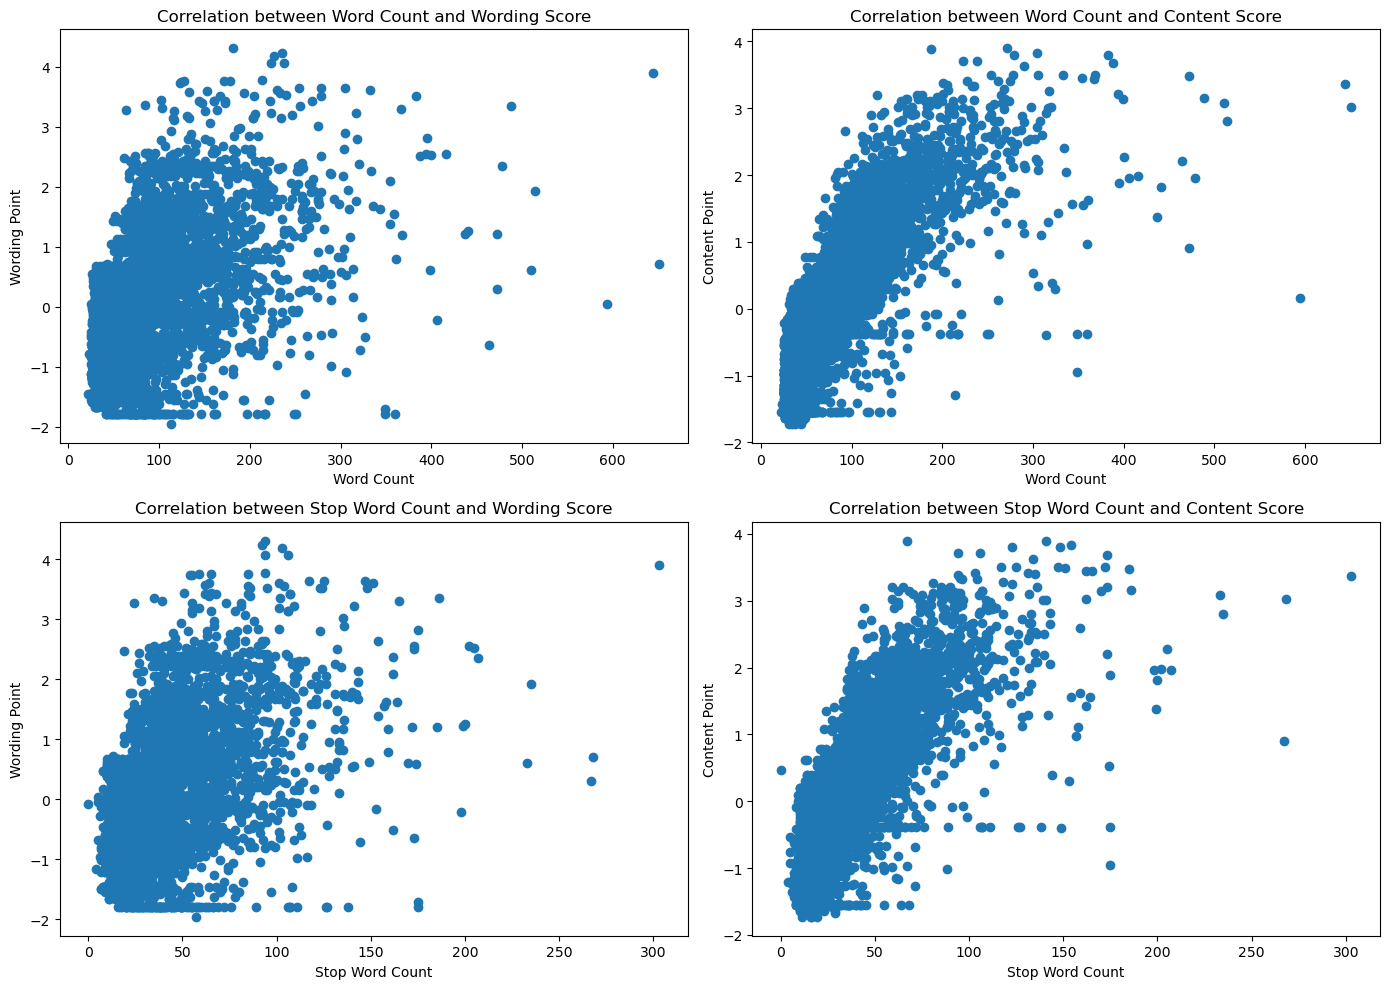

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].scatter(df_train.text_len, df_train.wording)
axs[0, 0].set_xlabel("Word Count")
axs[0, 0].set_ylabel("Wording Point")
axs[0, 0].set_title("Correlation between Word Count and Wording Score")

axs[0, 1].scatter(df_train.text_len, df_train.content)
axs[0, 1].set_xlabel("Word Count")
axs[0, 1].set_ylabel("Content Point")
axs[0, 1].set_title("Correlation between Word Count and Content Score")

axs[1, 0].scatter(df_train.stopword_count, df_train.wording)
axs[1, 0].set_xlabel("Stop Word Count")
axs[1, 0].set_ylabel("Wording Point")
axs[1, 0].set_title("Correlation between Stop Word Count and Wording Score")

axs[1, 1].scatter(df_train.stopword_count, df_train.content)
axs[1, 1].set_xlabel("Stop Word Count")
axs[1, 1].set_ylabel("Content Point")
axs[1, 1].set_title("Correlation between Stop Word Count and Content Score")

plt.tight_layout()
plt.show()


So there is a considerable contribution from the stop words to the summaries, but we can't remove stop words becuase they contribute to the wording score, otherwise we need them because deberta is trained on spell corrected sentences

# Research 5 - Hidden Details in prompts
source: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/436394



Augment prompts with the following [lexile](https://en.wikipedia.org/wiki/Lexile) information from the CommonLit website:

| Id | Title | Grade | Lexile |
| -- | ----- | ----- | ------ |
| 39c16e | [On Tragedy](https://www.commonlit.org/en/texts/on-tragedy) | 9 | 1070 |
| 3b9047 | [Egyptian Social Structure](https://www.commonlit.org/en/texts/egyptian-social-structure) | 7 | 890 |
| 814d6b | [The Third Wave](https://www.commonlit.org/en/texts/the-third-wave) | 9 | 1260 |
| ebad26 | [Excerpt from The Jungle](https://www.commonlit.org/en/texts/excerpt-from-the-jungle) | 11 | 1400 |

In [34]:
DT_prompts = df_train_prompt
DT_summaries = df_train_summaries
lexile_values = [1070, 890, 1260, 1400]
DT_prompts['lexile'] = lexile_values
DT_prompts

,prompt_id,prompt_question,prompt_title,prompt_text,lexile
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,1070
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,890
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,1260
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1400


In [35]:
!pip install textstat
import textstat

metrics = ["automated_readability_index",
           "coleman_liau_index",
           "dale_chall_readability_score",
           "flesch_reading_ease",
           "gunning_fog",
           "linsear_write_formula",
           "mcalpine_eflaw",
           "smog_index",
           "spache_readability"]

# Loop through each row and calculate the metrics
for i in range(len(DT_prompts)):
    text = DT_prompts.loc[i, "prompt_text"]
    for m in metrics:
        DT_prompts.loc[i, m] = getattr(textstat, m)(text)

# Displaying the updated DataFrame
print(DT_prompts.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.6 MB/s eta 0:00:0000:01
  prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  lexile  \
0  Chapter 13 \r\nAs the sequel to what has alrea...    1070   
1  Egyptian society was structured like a pyramid...     890   
2  Background \r\nThe Third Wave experiment took ...    1260   
3  With one member trimming beef in a cannery, an...    1400   

   automated_readabili

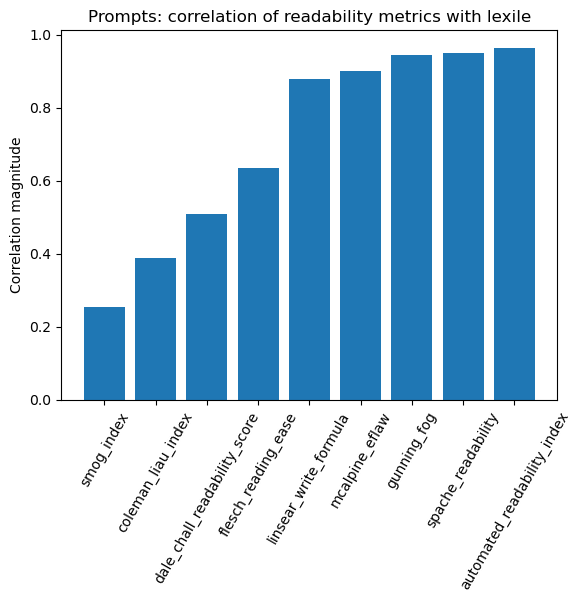

In [36]:
# Calculate correlations between the metrics and lexile.
corrs = []
for m in metrics:
    corr = DT_prompts['lexile'].corr(DT_prompts[m])
    corrs.append(abs(corr))

# Sort by correlation magnitude
index = sorted(range(len(corrs)), key=lambda k: corrs[k])
x = list(map(metrics.__getitem__, index))
y = list(map(corrs.__getitem__, index))

# Plotting
plt.bar(x=x, height=y)
plt.xticks(rotation=60)
plt.ylabel('Correlation magnitude')
plt.title('Prompts: correlation of readability metrics with lexile')
plt.show()


For the training texts lexile has very high (> 0.9) correlation with the `Gunning Fog`, `Spache Readability` and `Automated Readability indices` as calculated by textstat:

### Calculate readability metrics for the training summaries.

In [37]:
# Loop through each row and calculate the metrics
for i in range(len(DT_summaries)):
    text = DT_summaries.loc[i, "text"]
    for m in metrics:
        DT_summaries.loc[i, m] = getattr(textstat, m)(text)


In [38]:

# Display the DataFrame to see the added metrics
print(DT_summaries)

        student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0020ae56ffbf    ebad26   
2     004e978e639e    3b9047   
3     005ab0199905    3b9047   
4     0070c9e7af47    814d6b   
...            ...       ...   
7160  ff7c7e70df07    ebad26   
7161  ffc34d056498    3b9047   
7162  ffd1576d2e1b    3b9047   
7163  ffe4a98093b2    39c16e   
7164  fffbccfd8a08    ebad26   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     They would rub it up with soda to make the sme... -0.548304  0.506755   
2     In Egypt, there were many occupations and soci...  3.128928  4.231226   
3     The highest class was Pharaohs these people we... -0.210614 -0.471415   
4     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
...                                                 ...       ...       ...   
7160  They used all sorts of chemical concoctions to...  0.205

Calculate correlations between the summary metrics and content/wording scores

In [39]:
corrs = {"content": [], "wording": []}
for m in metrics:
    corr_content = DT_summaries['content'].corr(DT_summaries[m])
    corr_wording = DT_summaries['wording'].corr(DT_summaries[m])
    corrs["content"].append(abs(corr_content))
    corrs["wording"].append(abs(corr_wording))


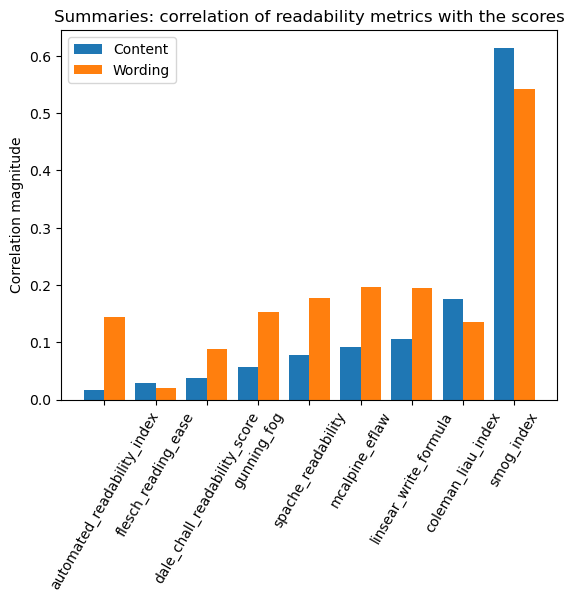

In [40]:
index = sorted(range(len(corrs["content"])), key=lambda k: corrs["content"][k])

x = list(map(metrics.__getitem__, index))
y_content = list(map(corrs["content"].__getitem__, index))
y_wording = list(map(corrs["wording"].__getitem__, index))

x_axis = np.arange(len(x))
plt.bar(x_axis-0.2, height=y_content, width=0.4, label="Content")
plt.bar(x_axis+0.2, height=y_wording, width=0.4, label="Wording")

plt.xticks(x_axis, x)
plt.xticks(rotation=60)
plt.ylabel('Correlation magnitude')
plt.title('Summaries: correlation of readability metrics with the scores')
plt.legend()
plt.show()

The popular readability metrics, [SMOG](https://en.wikipedia.org/wiki/SMOG) index was found to have the highest (> 0.5) correlation with the content/wording summary scores

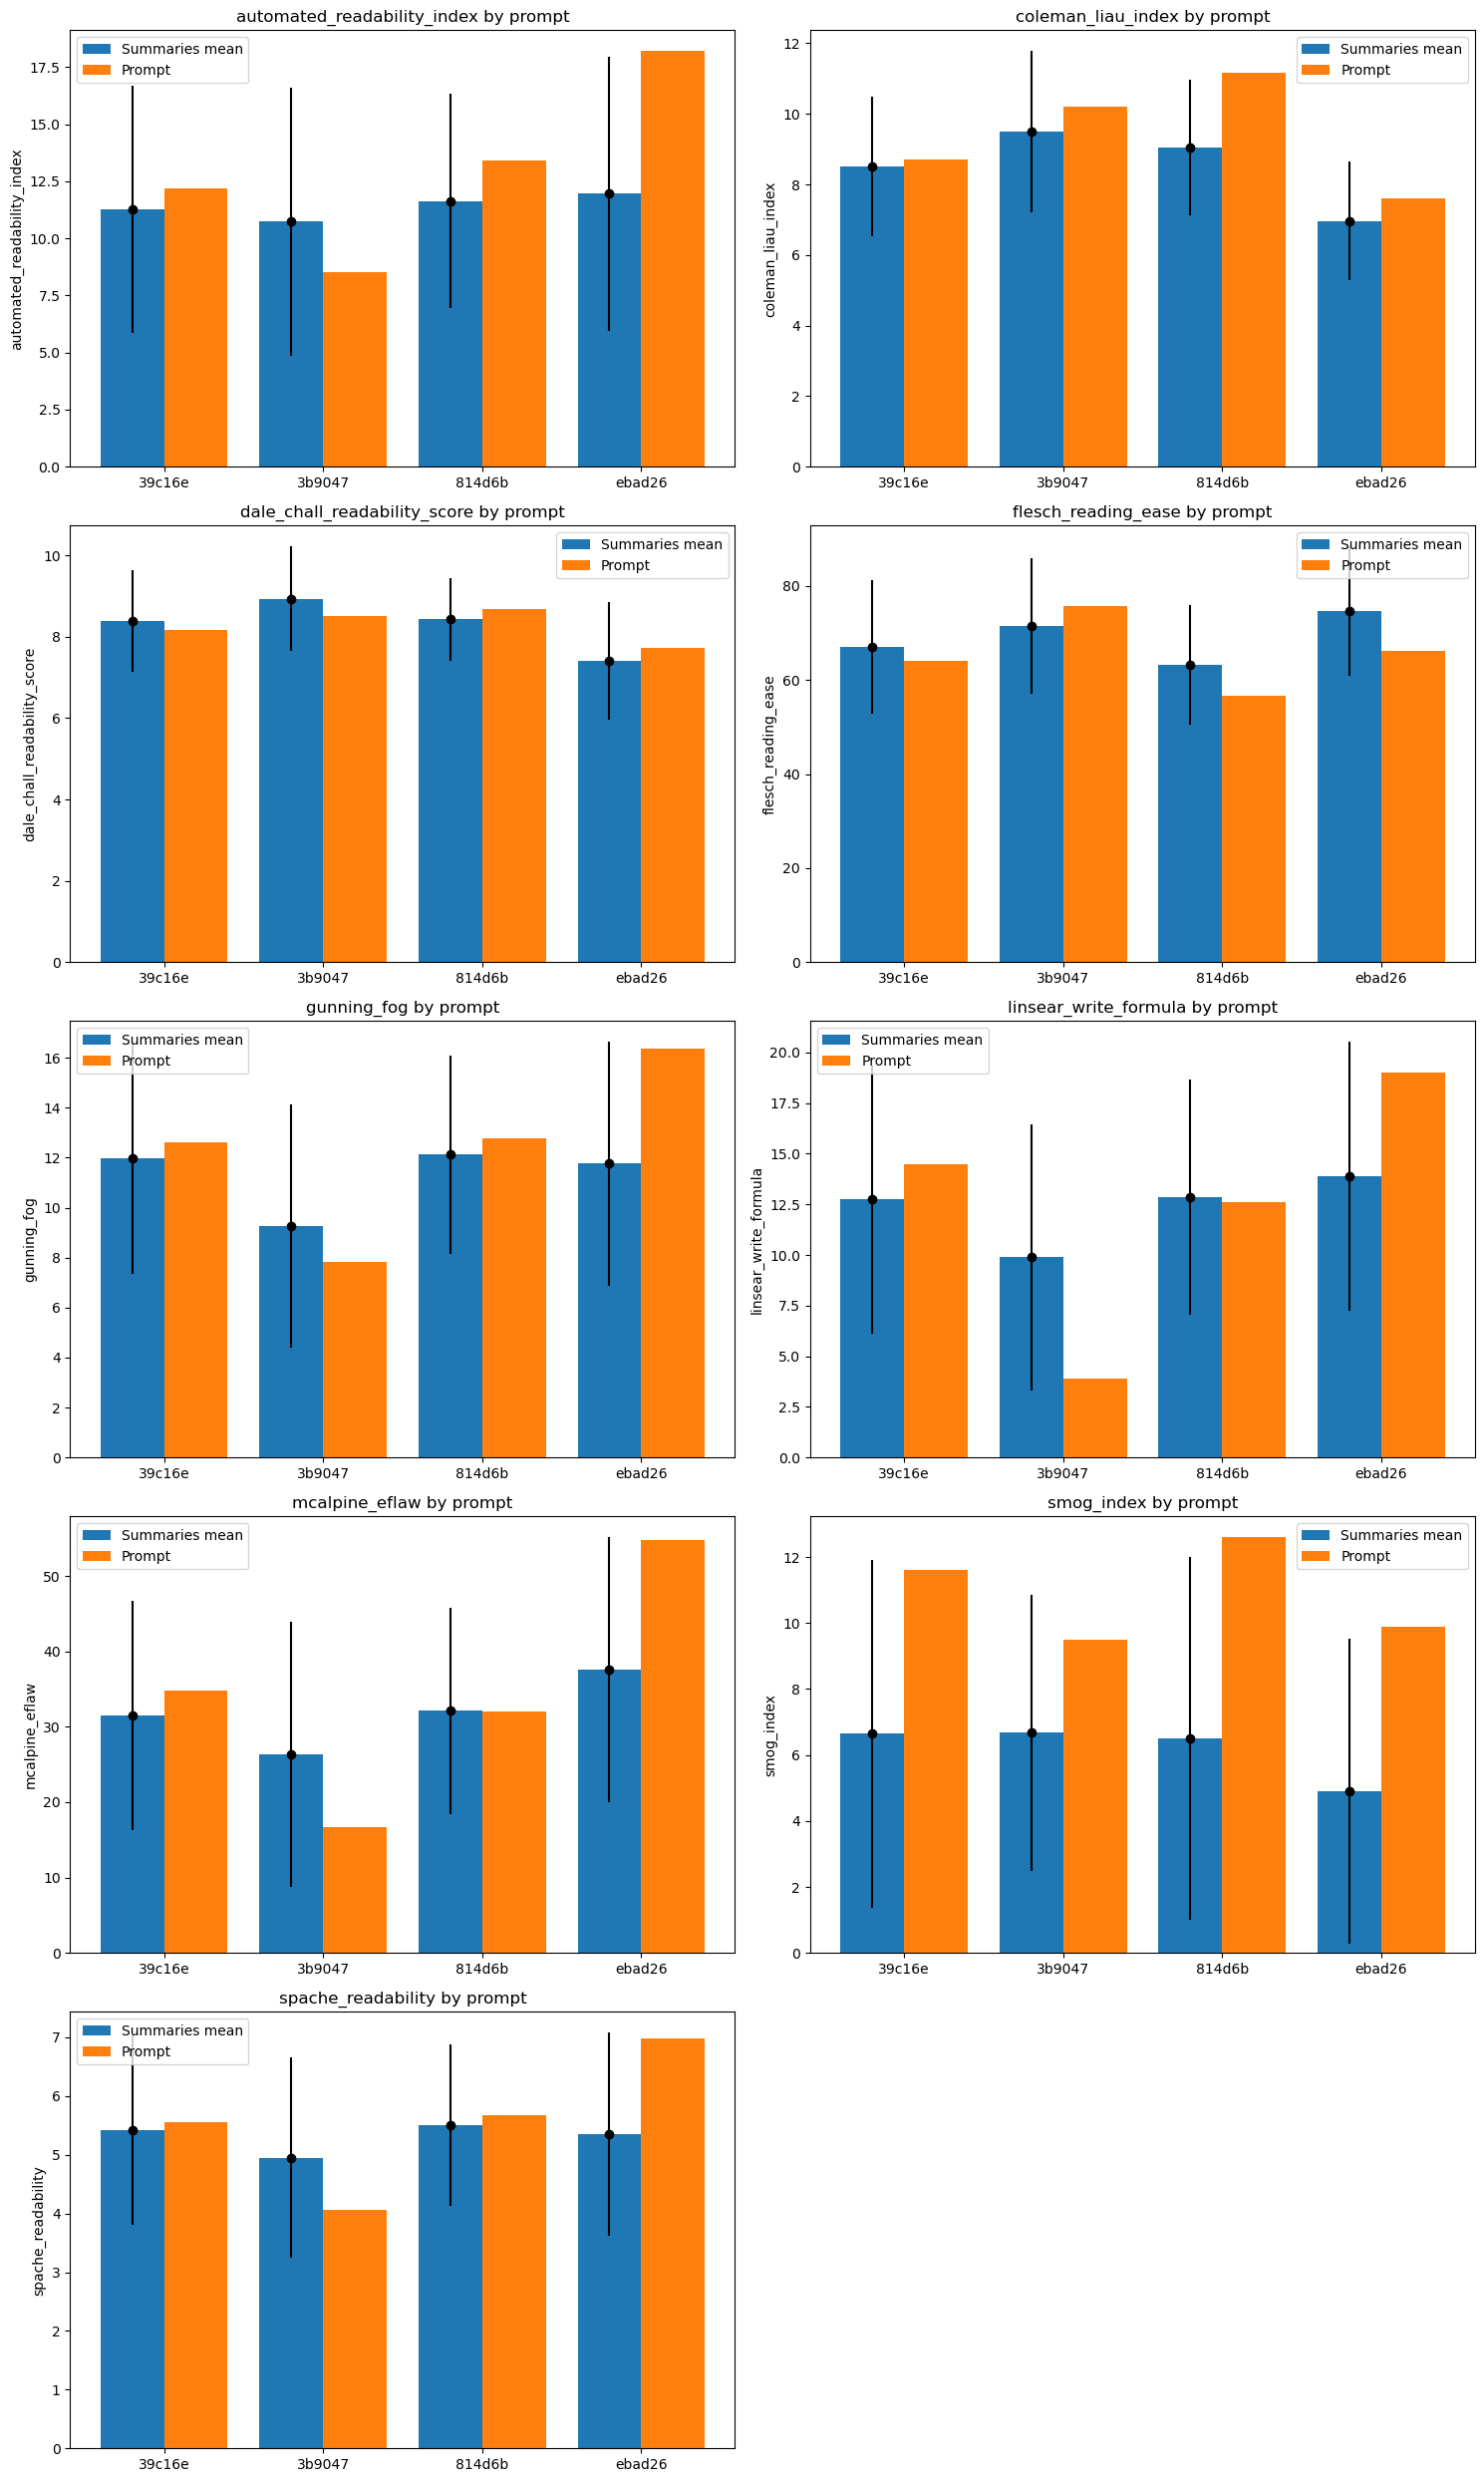

In [41]:

# Create subplots
n = len(metrics)
n_cols = 2  # Number of columns in the grid
n_rows = int(np.ceil(n / n_cols))  # Number of rows in the grid

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array if there's more than one subplot
if n > 1:
    axes = axes.flatten()

for i, m in enumerate(metrics):
    ax = axes[i] if n > 1 else axes

    # Calculate mean and standard deviation grouped by prompt_id
    DT_stats = DT_summaries.groupby('prompt_id').agg({m: ['mean', 'std']}).reset_index()

    # Convert specific columns to lists for plotting
    mean_values = DT_stats[(m, 'mean')].tolist()
    std_values = DT_stats[(m, 'std')].tolist()
    prompt_ids = DT_stats['prompt_id'].tolist()

    x_axis = np.arange(len(prompt_ids))

    # Plotting mean values with standard deviation as error bars for summaries
    ax.bar(x_axis - 0.2, height=mean_values, width=0.4, label="Summaries mean")
    ax.errorbar(x_axis - 0.2, y=mean_values, yerr=std_values, fmt="o", color="k")

    # Plotting metric values for prompts
    prompt_metric_values = DT_prompts[m].tolist()
    ax.bar(x_axis + 0.2, height=prompt_metric_values, width=0.4, label="Prompt")

    ax.set_xticks(x_axis)
    ax.set_xticklabels(prompt_ids)
    ax.set_ylabel(f'{m}')
    ax.set_title(f'{m} by prompt')
    ax.legend()

# Remove empty subplots if any
if n < n_rows * n_cols:
    for i in range(n, n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

## Conclusion

Lexile metrics, provided on the CommonLit website for full texts, cannot be easily calculated for summaries, because the lexile formula is not freely and publicaly available. However, lexile metrics has very high (> 0.9) correlation with the [gunning fog](https://en.wikipedia.org/wiki/Gunning_fog_index), [spache readability](https://en.wikipedia.org/wiki/Spache_readability_formula) and
[automated readability](https://en.wikipedia.org/wiki/Automated_readability_index) indices provided by `textstat`.

Further exploring the popular readability metrics, it was found that the [SMOG](https://en.wikipedia.org/wiki/SMOG) index has the highest (> 0.5) correlation with the content/wording summary scores. Also, for metrics like [Dale–Chall](https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula) or [Flesch Reading Ease](https://simple.wikipedia.org/wiki/Flesch_Reading_Ease) readabilities of summaries are in some correlation with the ones of the related prompts.

### Somebody has commented checkout why?
3-12 Grades (2397) Texts
Id Title Grade Lexile Genres
39c16e On Tragedy 9 1070 Philosophy
3b9047 Egyptian Social Structure 7 890 Informational Text
814d6b The Third Wave 9 1260 Informational Text
ebad26 Excerpt from The Jungle 11 1400 Fiction - General

700 Texts from (2397) Texts:
https://www.kaggle.com/datasets/olegpush/commonlit-text

Add Genres:
Fiction

Allegory
Drama
Fable
Fantasy
Fiction - General
Folktale
Historical Fiction
Magical Realism
Myth
Satire
Science Fiction
Short Story
displaying Non-Fiction Genres
Non-Fiction

Autobiography
Biography
Essay
Historical Document
Informational Text
Interview
Legal Document
Letter
Memoir
News
Non-Fiction - General
Opinion
Philosophy
Political Theory
Primary Source Document
Psychology
Religious Text
Speech
Poem